In [6]:
## Lauren Beard
## Final Project
## Professor Evans
## 170320

In [7]:
##################################
######### LOAD PACKAGES ##########
##################################

In [8]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
import lucem_illud_2020 #pip install git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
import requests #for http requests
import pandas as pd #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import wordcloud #Makes word clouds
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns #makes our plots look nicer
import sklearn.manifold #For a manifold plot
import json #For API responses
import urllib.parse #For joining urls

# comp-linguistics
import spacy

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook
%matplotlib inline

In [9]:
##################################
########## LOAD CORPUS ###########
####### ORGANIZE DATASETS ########
##################################

In [10]:
# Load corpus
corpus_name = "/Users/laurenbeard/Downloads/Movies/"

In [11]:
# This method extracts the text from the zip files and stroes the raw data.
def loadcorpus(corpus_name, corpus_style="text"):
    texts_raw = {}
    for file in os.listdir(corpus_name + "/"):
        if corpus_style in file:
            print(file)
            zfile = zipfile.ZipFile(corpus_name + "/" + file)
            for file in zfile.namelist():
                texts_raw[file] = []
                with zfile.open(file) as f:
                    for line in f:
                        texts_raw[file].append(line)
    return texts_raw

In [12]:
movie_raw = loadcorpus(corpus_name)

text_13_idi.zip
text_16_qll.zip
text_32_ldf.zip
text_19_gvc.zip
text_05_nko.zip
text_17_arp.zip
text_01_ote.zip
text_28_rfy.zip
text_31_akv.zip
text_22_etp.zip
text_11_uoy.zip
text_09_oii.zip
text_06_jfy.zip
text_14_lnc.zip
text_08_loh.zip
text_33_kje.zip
text_30_wkp.zip
text_07_oma.zip
text_03_mnq.zip
text_21_fqa.zip
text_29_oye.zip
text_27_fle.zip
text_23_fmh.zip
text_12_rcq.zip
text_00_myn.zip
text_10_aoy.zip
text_04_mlq.zip
text_20_cde.zip
text_02_mqu.zip
text_26_ngj.zip
text_24_ywo.zip
text_18_jfj.zip
text_25_byg.zip
text_15_guo.zip


In [13]:
# Load the spaCy english model
nlp = spacy.load("en")

In [14]:
# Further extracting from movie corpus
zfile = zipfile.ZipFile(corpus_name + "/sources_movies.zip")
source = []
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [15]:
source[0:10]

[b'textID\tfileID\t#words\tgenre\tyear\tlanguage(s)\tcountry\timdb\ttitle\r\n',
 b'-----\t-----\t-----\t-----\t-----\t-----\t-----\t-----\t-----\r\n',
 b'\r\n',
 b'290635\t3547424\t4722\tShort, Musical\t1930\tUK\tEnglish\t0290635\tGoodbye to All That\r\n',
 b'21165\t6332374\t10220\tCrime, Mystery, Thriller\t1930\tUK\tEnglish\t0021165\tMurder!\r\n',
 b'21191\t6013789\t5281\tDrama, Romance\t1930\tUSA\tEnglish\t0021191\tA Notorious Affair\r\n',
 b'20620\t3660608\t6724\tBiography, Drama, History\t1930\tUSA\tEnglish\t0020620\tAbraham Lincoln\r\n',
 b'20629\t60053\t9552\tDrama, War\t1930\tUSA\tEnglish, French, German, Latin\t0020629\tAll Quiet on the Western Front\r\n',
 b'20640\t6850720\t13862\tComedy, Musical\t1930\tUSA\tEnglish\t0020640\tAnimal Crackers\r\n',
 b'20641\t176501\t11140\tDrama, Romance\t1930\tUSA\tEnglish\t0020641\tAnna Christie\r\n']

In [16]:
# This basic method replaces some of the issues with the formatting, and prints the errors if any for debugging. 
# Let us clean one of the raw text files.
def clean_raw_text(raw_texts):
    clean_texts = []
    for text in raw_texts:
        try:
            text = text.decode("utf-8")
            clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
            clean_texts.append(clean_text)
        except AttributeError:
            # print("ERROR CLEANING")
            # print(text)
            continue
        except UnicodeDecodeError:
            # print("Unicode Error, Skip")
            continue
    return clean_texts

In [17]:
# Create dictionary
movie_texts = {}
movie_nontokenized_texts = {}

# here create tokenized data
## my goal: create a text column
for files in movie_raw:
    if len(movie_texts) > 5:
        break
    ## pull from movies to get text data? (thought that I could just incorporate movies in the for loop below)
    movies = clean_raw_text(movie_raw[files][1:])
    # here we create the tokenized data:
    for movie in movies:
        txts = lucem_illud_2020.word_tokenize(movie)
        non_token_txts = movie
        ## this is creating a dictionary where the id maps to the text
        ## txts[0][2:] is the movie id which I've squeezed out
        try:
            movie_texts[txts[0][2:]] = txts[1:]
            movie_nontokenized_texts[txts[0][2:]] = movie
        except IndexError:
            continue

In [18]:
# Create columns
movie_df = pd.DataFrame(columns=["Movie Name", "Genre", "Year", "Country","Text", "Tokenized Texts"])

## Pull out the movie from the untokenized dictionary
for movie in source[3:]:
    try:
        tid, fileid, total_words, genre, year, lang, country, imdb, title = movie.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    try:
        movie_df.loc[fileid.strip()] = [title.strip(), genre.strip(), year.strip(), country.strip(), movie_nontokenized_texts[fileid.strip()], movie_texts[fileid.strip()]]
    except KeyError:
        continue

In [19]:
# Print out data frame
movie_df.head()

,Movie Name,Genre,Year,Country,Text,Tokenized Texts
6850720,Animal Crackers,"Comedy, Musical",1930,English,@@6850720 You must do your best tonight Be on ...,"[You, must, do, your, best, tonight, Be, on, y..."
176501,Anna Christie,"Drama, Romance",1930,English,@@176501 Either you're flat or I am . I beg yo...,"[Either, you, 're, flat, or, I, am, I, beg, yo..."
4056770,Ladies of Leisure,"Drama, Romance",1930,English,@@4056770 Look out ! There's another bottle co...,"[Look, out, There, 's, another, bottle, coming..."
5992934,Over the Hill,Drama,1931,English,"@@5992934 Good morning , kitty ! Come in here ...","[Good, morning, kitty, Come, in, here, baby, I..."
4436137,Design for Living,"Comedy, Romance",1933,"English, French",@@4436137 [Train_engine_grinding] **26;1426;TO...,"[Train_engine_grinding, 26;1426;TOOLONG, Whist..."


In [20]:
# Count words in tokenized text
countsDict = {}
for word in movie_df['Tokenized Texts'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)

In [21]:
word_counts[:10]

[('I', 195456),
 ('you', 157144),
 ('the', 133974),
 ('to', 109659),
 ("'s", 98102),
 ('a', 92462),
 ('it', 67064),
 ("n't", 65593),
 ('of', 57693),
 ('that', 55459)]

In [22]:
# normalize function
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [23]:
# Normalize text
movie_df['normalized_tokens'] = movie_df['Tokenized Texts'].apply(lambda x: normalizeTokens(x))
movie_df['normalized_tokens_count'] = movie_df['normalized_tokens'].apply(lambda x: len(x))

In [24]:
# Define parts-of-speech function
def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

In [25]:
# Generate POS column
movie_df['normalized_tokens_POS'] = [spacy_pos(t) for t in movie_df['Text']]

In [111]:
# Generate tokenized sentences and normalized sentences
movie_df['tokenized_sents'] = movie_df['Text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
movie_df['normalized_sents'] = movie_df['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [182]:
# Tokenized and normalized words
movie_df['tokenized_words'] = movie_df['Text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
movie_df['normalized_words'] = movie_df['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

In [184]:
movie_df.head()

,Movie Name,Genre,Year,Country,Text,Tokenized Texts,normalized_tokens,normalized_tokens_count,normalized_tokens_POS,tokenized_sents,normalized_sents,tokenized_words,normalized_words
6850720,Animal Crackers,"Comedy, Musical",1930,English,@@6850720 You must do your best tonight Be on ...,"[You, must, do, your, best, tonight, Be, on, y...","[good, tonight, toe, man, guest, tonight, man,...",4868,"[(@@6850720, IN), (you, PRP), (must, MD), (do,...","[[@@6850720, You, must, do, your, best, tonigh...","[[@@6850720, well, tonight], [toe, man], [gues...","[@@6850720, You, must, do, your, best, tonight...","[@@6850720, best, tonight, toes, men, guest, t..."
176501,Anna Christie,"Drama, Romance",1930,English,@@176501 Either you're flat or I am . I beg yo...,"[Either, you, 're, flat, or, I, am, I, beg, yo...","[flat, beg, pardon, excuse, lady, frighten, hi...",3825,"[(@@176501, UH), (either, CC), (you, PRP), ('r...","[[@@176501, Either, you, 're, flat, or, I, am]...","[[@@176501, flat], [beg, pardon], [excuse], [l...","[@@176501, Either, you, 're, flat, or, I, am, ...","[@@176501, flat, beg, pardon, excuse, lady, fr..."
4056770,Ladies of Leisure,"Drama, Romance",1930,English,@@4056770 Look out ! There's another bottle co...,"[Look, out, There, 's, another, bottle, coming...","[look, bottle, come, look, look, come, let, th...",3195,"[(@@4056770, NNP), (look, VB), (out, RP), (!, ...","[[@@4056770], [Look, out], [There, 's, another...","[[@@4056770], [look], [bottle, come], [look], ...","[@@4056770, Look, out, There, 's, another, bot...","[@@4056770, look, bottle, coming, look, look, ..."
5992934,Over the Hill,Drama,1931,English,"@@5992934 Good morning , kitty ! Come in here ...","[Good, morning, kitty, Come, in, here, baby, I...","[good, morning, kitty, come, baby, isaac, tomm...",2651,"[(@@5992934, NNP), (good, JJ), (morning, NN), ...","[[@@5992934], [Good, morning, kitty], [Come, i...","[[@@5992934], [good, morning, kitty], [come, b...","[@@5992934, Good, morning, kitty, Come, in, he...","[@@5992934, good, morning, kitty, come, baby, ..."
4436137,Design for Living,"Comedy, Romance",1933,"English, French",@@4436137 [Train_engine_grinding] **26;1426;TO...,"[Train_engine_grinding, 26;1426;TOOLONG, Whist...","[train_engine_grinde, 26;1426;toolong, whistle...",3417,"[(@@4436137, IN), ([, -LRB-), (train_engine_gr...","[[@@4436137, Train_engine_grinding], [], [26;1...","[[@@4436137, train_engine_grinding], [], [26;1...","[@@4436137, Train_engine_grinding, 26;1426;TOO...","[@@4436137, train_engine_grinding, 26;1426;too..."


In [185]:
# Set up for histogram of years
movie_df.dtypes

Movie Name                 object
Genre                      object
Year                        int64
Country                    object
Text                       object
Tokenized Texts            object
normalized_tokens          object
normalized_tokens_count     int64
normalized_tokens_POS      object
tokenized_sents            object
normalized_sents           object
tokenized_words            object
normalized_words           object
dtype: object

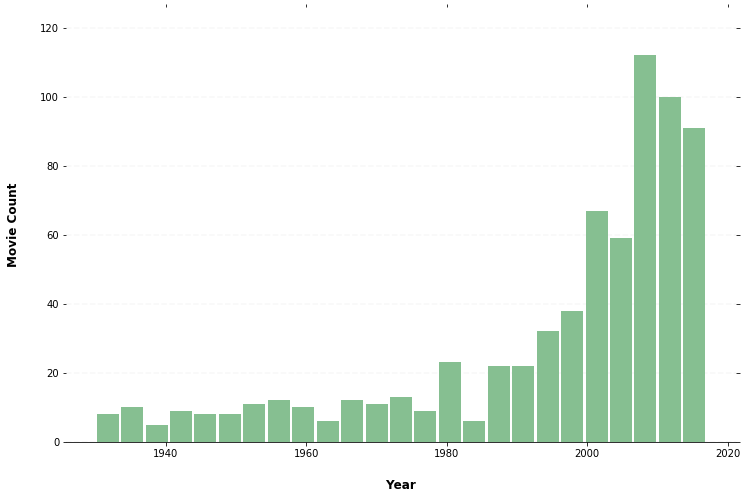

In [186]:
# Histogram of Years
movie_df['Year'] = movie_df['Year'].astype(str).astype(int)
ax = movie_df.hist(column='Year', bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Year", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Movie Count", labelpad=20, weight='bold', size=12)

In [187]:
# Bin these movies on the basis of 20 years intervals
# Output value counts per years to ensure correct binning

In [188]:
## Step 1a: Remove all movies before 1940 to get overall dataframe
movie_df_1940_2020 = movie_df[movie_df['Year'] > 1939]
movie_df_1940_2020['Year'].value_counts()

2012    35
2008    33
2013    33
2011    32
2007    29
        ..
1948     1
1974     1
1970     1
1956     1
1940     1
Name: Year, Length: 74, dtype: int64

In [189]:
## Step 1b: Get length of subset
len(movie_df_1940_2020)

682

In [190]:
## Step 2a: 1940-1960 subset
movie_df_1940_1960 = movie_df[movie_df['Year'] < 1961]
movie_df_1940_1960['Year'].value_counts()

1955    7
1951    5
1959    4
1933    4
1957    4
1936    4
1949    4
1944    3
1934    3
1935    3
1941    3
1942    3
1943    3
1930    3
1947    3
1950    3
1952    3
1953    3
1958    3
1945    2
1938    2
1948    1
1940    1
1939    1
1937    1
1956    1
1931    1
1960    1
Name: Year, dtype: int64

In [191]:
## Step 2b: Get length of subset
len(movie_df_1940_1960)

79

In [192]:
## Step 3a: 1960-1980 subset
movie_df_1960_1980 = movie_df_1940_2020[(movie_df_1940_2020.Year >= 1960) & (movie_df_1940_2020.Year <= 1979)]
movie_df_1960_1980['Year'].value_counts()

1979    10
1971     6
1975     5
1962     4
1977     4
1972     4
1969     4
1965     4
1973     3
1978     3
1968     3
1967     3
1976     2
1961     2
1966     2
1964     2
1970     1
1974     1
1960     1
Name: Year, dtype: int64

In [193]:
## Step 3b: Get length of subset
len(movie_df_1960_1980)

64

In [194]:
## Step 4a: 1980-2000 subset
movie_df_1980_2000 = movie_df_1940_2020[(movie_df_1940_2020.Year >= 1980) & (movie_df_1940_2020.Year <= 1999)]
movie_df_1980_2000['Year'].value_counts()

1998    16
1999    13
1996    12
1990    12
1997     9
1989     8
1995     7
1994     7
1992     7
1993     6
1987     6
1982     6
1988     5
1985     4
1980     4
1991     3
1986     3
1981     3
1983     2
Name: Year, dtype: int64

In [195]:
## Step 4b: Get length of subset
len(movie_df_1980_2000)

133

In [196]:
## Step 5a: 1980-2020 subset
movie_df_2000_2020 = movie_df_1940_2020[(movie_df_1940_2020.Year >= 2000) & (movie_df_1940_2020.Year <= 2019)]
movie_df_2000_2020['Year'].value_counts()

2012    35
2008    33
2013    33
2011    32
2014    29
2007    29
2016    28
2010    27
2004    24
2006    24
2015    23
2009    23
2001    18
2000    17
2003    16
2002    16
2005    11
2017    11
Name: Year, dtype: int64

In [197]:
## Step 5b: Get length of subset
len(movie_df_2000_2020)

429

In [198]:
# Get the count of each genre
movie_df['Genre'].value_counts()

Drama                           43
Comedy                          36
Comedy, Drama, Romance          27
Documentary                     27
Drama, Romance                  20
                                ..
Animation, Adventure, Sci-Fi     1
Fantasy, Romance                 1
Mystery, Drama, Fantasy          1
Biography, Drama, Musical        1
Adventure, Sci-Fi                1
Name: Genre, Length: 266, dtype: int64

In [199]:
# Note that the top three genre styles are:
# 1: drama, 2: comedy, 3: documentary

In [200]:
# Make a single-genre dataframe using the top 3 genre-styles
movieSingleGenre = movie_df.set_index(['Genre'])
movieGenre = movieSingleGenre.loc[movieSingleGenre.index.isin(['Drama','Comedy','Documentary'])]
movieGenre.head()

,Movie Name,Year,Country,Text,Tokenized Texts,normalized_tokens,normalized_tokens_count,normalized_tokens_POS,tokenized_sents,normalized_sents,tokenized_words,normalized_words
Genre,,,,,,,,,,,,
Drama,Over the Hill,1931,English,"@@5992934 Good morning , kitty ! Come in here ...","[Good, morning, kitty, Come, in, here, baby, I...","[good, morning, kitty, come, baby, isaac, tomm...",2651,"[(@@5992934, NNP), (good, JJ), (morning, NN), ...","[[@@5992934], [Good, morning, kitty], [Come, i...","[[@@5992934], [good, morning, kitty], [come, b...","[@@5992934, Good, morning, kitty, Come, in, he...","[@@5992934, good, morning, kitty, come, baby, ..."
Comedy,A Chump at Oxford,1940,English,"@@3904983 Well , what's the matter now ? - I j...","[Well, what, 's, the, matter, now, I, just, sa...","[matter, see, hand, siddown, crazy, ve, go, ci...",1056,"[(@@3904983, UH), (well, UH), (,, ,), (what, W...","[[@@3904983], [Well, what, 's, the, matter, no...","[[@@3904983], [matt], [see, hand], [siddown], ...","[@@3904983, Well, what, 's, the, matter, now, ...","[@@3904983, matter, saw, hands, siddown, crazy..."
Comedy,The Happiest Days of Your Life,1950,English,"@@6017201 BIG BEN CHIMES Excuse me , could you...","[BIG, BEN, CHIMES, Excuse, me, could, you, tel...","[big, ben, chime, excuse, tell, way, nutbourne...",4247,"[(@@6017201, NFP), (big, NNP), (ben, NNP), (ch...","[[@@6017201], [BIG, BEN, CHIMES, Excuse, me, c...","[[@@6017201], [big, ben, chime, excuse, tell, ...","[@@6017201, BIG, BEN, CHIMES, Excuse, me, coul...","[@@6017201, big, ben, chimes, excuse, tell, wa..."
Drama,The Company She Keeps,1951,English,@@6860500 If no-one has any objections . I was...,"[If, no, one, has, any, objections, I, was, wo...","[objection, wonder, mildred, lynch, possible, ...",3067,"[(@@6860500, IN), (if, IN), (no, DT), (-, HYPH...","[[@@6860500, If, no, one, has, any, objections...","[[@@6860500, objection], [wonder, mildred, lyn...","[@@6860500, If, no, one, has, any, objections,...","[@@6860500, objections, wondering, mildred, ly..."
Drama,My Son John,1952,English,"@@4788308 What's the matter , pop ? You're get...","[What, 's, the, matter, pop, You, 're, gettin,...","[matter, pop, gettin, kinda, clumsy, huh, boy,...",4916,"[(@@4788308, UH), (what, WP), ('s, VBZ), (the,...","[[@@4788308], [What, 's, the, matter, pop], [Y...","[[@@4788308], [matt, pop], [gettin, kinda, clu...","[@@4788308, What, 's, the, matter, pop, You, '...","[@@4788308, matter, pop, gettin, kinda, clumsy..."


In [201]:
# Make separate genre dataframes
movieDrama = movieGenre.loc[movieGenre.index.isin(['Drama'])]
movieComedy = movieGenre.loc[movieGenre.index.isin(['Comedy'])]
movieDoc = movieGenre.loc[movieGenre.index.isin(['Documentary'])]

In [202]:
movieDoc.head()

,Movie Name,Year,Country,Text,Tokenized Texts,normalized_tokens,normalized_tokens_count,normalized_tokens_POS,tokenized_sents,normalized_sents,tokenized_words,normalized_words
Genre,,,,,,,,,,,,
Documentary,The Reincarnation of Khensur Rinpoche,1992,English,@@3083349 Look ! Kanako was a penguin ! Why wa...,"[Look, Kanako, was, a, penguin, Why, was, I, a...","[look, kanako, penguin, penguin, hilarious, cu...",983,"[(@@3083349, NNP), (look, VB), (!, .), (kanako...","[[@@3083349, Look], [Kanako, was, a, penguin],...","[[@@3083349, look], [kanako, penguin], [pengui...","[@@3083349, Look, Kanako, was, a, penguin, Why...","[@@3083349, look, kanako, penguin, penguin, hi..."
Documentary,Titanic: Untold Stories,1998,English,@@3341525 The builder who would pronounce her ...,"[The, builder, who, would, pronounce, her, dea...","[builder, pronounce, dead, brave, man, refuse,...",1978,"[(@@3341525, NNP), (the, DT), (builder, NN), (...","[[@@3341525], [The, builder, who, would, prono...","[[@@3341525], [builder, pronounce, dead], [bra...","[@@3341525, The, builder, who, would, pronounc...","[@@3341525, builder, pronounce, dead, brave, m..."
Documentary,S Club 7 - It's an S Club Thing,1999,English,"@@215393 C is the chicken , E is egg in the tr...","[C, is, the, chicken, E, is, egg, in, the, tro...","[c, chicken, e, egg, trouser, hang, pant, dire...",1479,"[(@@215393, NNP), (c, NNP), (is, VBZ), (the, D...","[[@@215393, C, is, the, chicken, E, is, egg, i...","[[@@215393, c, chicken, e, egg, trouser], [han...","[@@215393, C, is, the, chicken, E, is, egg, in...","[@@215393, c, chicken, e, egg, trouser, hangin..."
Documentary,The Making of 'Walking with Dinosaurs',1999,English,@@4288799 ' If a film crew ventured back 65 mi...,"[If, a, film, crew, ventured, back, 65, millio...","[film, crew, venture, year, dinosaur, natural,...",2005,"[(@@4288799, IN), (', ''), (if, IN), (a, DT), ...","[[@@4288799, If, a, film, crew, ventured, back...","[[@@4288799, film, crow, venture, year, dinosa...","[@@4288799, If, a, film, crew, ventured, back,...","[@@4288799, film, crew, ventured, years, dinos..."
Documentary,Hate.Com: Extremists on the Internet,2000,English,@@148052 Thanks for the information . There's ...,"[Thanks, for, the, information, There, 's, no,...","[thank, information, chance, mistake, oh, rule...",2472,"[(@@148052, RB), (thanks, NNS), (for, IN), (th...","[[@@148052], [Thanks, for, the, information], ...","[[@@148052], [thank, information], [chance, mi...","[@@148052, Thanks, for, the, information, Ther...","[@@148052, thanks, information, chance, mistak..."


In [203]:
# Save out these dataframes
## Overall dataframe
movie_df.to_csv("/Users/laurenbeard/Desktop/compContentAnalysis/Content-Analysis-2020/final/movie_df.csv") 

# Dataframes by Year
movie_df_1940_2020.to_csv("/Users/laurenbeard/Desktop/compContentAnalysis/Content-Analysis-2020/final/movie_df_1940_2020.csv") 
movie_df_1940_1960.to_csv("/Users/laurenbeard/Desktop/compContentAnalysis/Content-Analysis-2020/final/movie_df_1940_1960.csv")
movie_df_1960_1980.to_csv("/Users/laurenbeard/Desktop/compContentAnalysis/Content-Analysis-2020/final/movie_df_1960_1980.csv")
movie_df_1980_2000.to_csv("/Users/laurenbeard/Desktop/compContentAnalysis/Content-Analysis-2020/final/movie_df_1980_2000.csv")
movie_df_2000_2020.to_csv("/Users/laurenbeard/Desktop/compContentAnalysis/Content-Analysis-2020/final/movie_df_2000_2020.csv")

# Dataframe by genre
movieGenre.to_csv("/Users/laurenbeard/Desktop/compContentAnalysis/Content-Analysis-2020/final/movie_df_genre.csv")
movieDrama.to_csv("/Users/laurenbeard/Desktop/compContentAnalysis/Content-Analysis-2020/final/movieDrama.csv")
movieComedy.to_csv("/Users/laurenbeard/Desktop/compContentAnalysis/Content-Analysis-2020/final/movieComedy.csv")
movieDoc.to_csv("/Users/laurenbeard/Desktop/compContentAnalysis/Content-Analysis-2020/final/movieDoc.csv")

In [ ]:
################################################
########## COUNTING WORDS AND PHRASES ##########
################################################

In [46]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
import lucem_illud_2020 #pip install git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
import requests #for http requests
import pandas as pd #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import wordcloud #Makes word clouds
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns #makes our plots look nicer
import sklearn.manifold #For a manifold plot
import json #For API responses
import urllib.parse #For joining urls

# comp-linguistics
import spacy

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook
%matplotlib inline

import nltk

In [47]:
nlp = spacy.load("en")

In [48]:
def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [ ]:
################################################
########## COUNTING WORDS AND PHRASES ##########
############## YEARS SUB-ANALYSIS ##############
################################################

In [49]:
countsDict = {}
for word in movie_df_1940_2020['Tokenized Texts'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts_1940_2020 = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)

In [50]:
countsDict = {}
for word in movie_df_1940_1960['Tokenized Texts'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts_1940_1960 = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)

In [51]:
countsDict = {}
for word in movie_df_2000_2020['Tokenized Texts'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts_2000_2020 = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)

In [52]:
word_counts_1940_2020[:5]

[('I', 188719),
 ('you', 151095),
 ('the', 129730),
 ('to', 105982),
 ("'s", 94732)]

In [53]:
word_counts_1940_1960[:5]

[('I', 25560), ('you', 21990), ('the', 15816), ('to', 14805), ('a', 12322)]

In [54]:
word_counts_2000_2020[:5]

[('I', 116959), ('you', 92918), ('the', 81305), ('to', 65731), ("'s", 59548)]

In [55]:
# .sum() adds together the lists from each row into a single list
moviecfdist_1940_2020 = nltk.ConditionalFreqDist(((len(w), w) for w in movie_df_1940_2020['normalized_tokens'].sum()))

#print the number of words
print(moviecfdist_1940_2020.N())

1969430


In [56]:
# .sum() adds together the lists from each row into a single list
moviecfdist_1940_1960 = nltk.ConditionalFreqDist(((len(w), w) for w in movie_df_1940_1960['normalized_tokens'].sum()))

#print the number of words
print(moviecfdist_1940_1960.N())

240034


In [57]:
# .sum() adds together the lists from each row into a single list
moviecfdist_2000_2020 = nltk.ConditionalFreqDist(((len(w), w) for w in movie_df_2000_2020['normalized_tokens'].sum()))

#print the number of words
print(moviecfdist_2000_2020.N())

1230444


In [58]:
moviecpdist_1940_2020 = nltk.ConditionalProbDist(moviecfdist_1940_2020, nltk.ELEProbDist)

#print the most common 2 letter word
print(moviecpdist_1940_2020[2].max())

#And its probability
print(moviecpdist_1940_2020[2].prob(moviecpdist_1940_2020[2].max()))

oh
0.18557326285477604


In [59]:
moviecpdist_1940_1960 = nltk.ConditionalProbDist(moviecfdist_1940_1960, nltk.ELEProbDist)

#print the most common 2 letter word
print(moviecpdist_1940_1960[2].max())

#And its probability
print(moviecpdist_1940_1960[2].prob(moviecpdist_1940_1960[2].max()))

oh
0.20074623965175484


In [60]:
moviecpdist_2000_2020 = nltk.ConditionalProbDist(moviecfdist_2000_2020, nltk.ELEProbDist)

#print the most common 2 letter word
print(moviecpdist_2000_2020[2].max())

#And its probability
print(moviecpdist_2000_2020[2].prob(moviecpdist_2000_2020[2].max()))

oh
0.19357483423677277


In [61]:
def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

In [62]:
moviecfdist_1940_2020_WordtoPOS = nltk.ConditionalFreqDist(movie_df_1940_2020['normalized_tokens_POS'].sum())
list(moviecfdist_1940_2020_WordtoPOS.items())[:10]

[('@@3904983', FreqDist({'UH': 1})),
 ('well', FreqDist({'UH': 12386, 'RB': 2863, 'JJ': 109, 'NN': 41, 'VBP': 1})),
 (',', FreqDist({',': 309179})),
 ('what', FreqDist({'WP': 46477, 'WDT': 1567})),
 ("'s",
  FreqDist({'VBZ': 75951, 'POS': 14366, 'PRP': 5688, 'NNP': 5, '``': 4, 'NN': 3, 'ADD': 1})),
 ('the', FreqDist({'DT': 147522, 'NN': 1})),
 ('matter',
  FreqDist({'NN': 1086, 'VB': 411, 'RB': 308, 'VBP': 5, 'NNP': 5, 'JJ': 4})),
 ('now', FreqDist({'RB': 15744, 'UH': 321})),
 ('?',
  FreqDist({'.': 157938, ',': 1644, 'NNP': 101, 'NN': 16, 'RB': 2, 'SYM': 1})),
 ('-',
  FreqDist({':': 112284, 'HYPH': 26643, ',': 834, 'NN': 421, 'JJ': 380, 'SYM': 309, '.': 172, 'NNS': 81, 'VB': 47, 'NFP': 46, ...}))]

In [63]:
moviecfdist_1940_1960_WordtoPOS = nltk.ConditionalFreqDist(movie_df_1940_1960['normalized_tokens_POS'].sum())
list(moviecfdist_1940_1960_WordtoPOS.items())[:10]

[('@@6850720', FreqDist({'IN': 1})),
 ('you', FreqDist({'PRP': 28254})),
 ('must', FreqDist({'MD': 754, 'NNP': 1})),
 ('do', FreqDist({'VBP': 5148, 'VB': 3034, 'NN': 1})),
 ('your', FreqDist({'PRP$': 4406})),
 ('best', FreqDist({'JJS': 179, 'RBS': 10, 'RB': 4})),
 ('tonight', FreqDist({'NN': 356})),
 ('be', FreqDist({'VB': 3943, 'VBP': 25})),
 ('on', FreqDist({'IN': 2698, 'RP': 1325, 'RB': 75})),
 ('toes', FreqDist({'NNS': 15}))]

In [64]:
moviecfdist_2000_2020_WordtoPOS = nltk.ConditionalFreqDist(movie_df_2000_2020['normalized_tokens_POS'].sum())
list(moviecfdist_2000_2020_WordtoPOS.items())[:10]

[('@@3896765', FreqDist({'NNP': 1})),
 ('claude', FreqDist({'NN': 30, 'NNP': 24, 'VB': 3, 'JJ': 2, 'VBP': 1})),
 (',', FreqDist({',': 195323})),
 ('leave', FreqDist({'VB': 1572, 'VBP': 222, 'NN': 20, 'NNP': 2})),
 ('them', FreqDist({'PRP': 5346})),
 ('there', FreqDist({'EX': 6652, 'RB': 6527})),
 ('.',
  FreqDist({'.': 340143, 'NNP': 5073, 'NN': 48, 'RB': 3, 'SYM': 1, 'FW': 1, ',': 1})),
 ('i', FreqDist({'PRP': 118294, 'NNP': 110, 'NN': 6})),
 ("'ll", FreqDist({'MD': 10001})),
 ('come', FreqDist({'VB': 8928, 'VBP': 767, 'VBN': 394, 'NN': 15, 'VBD': 5}))]

In [66]:
moviecfdist_1940_2020_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in movie_df_1940_2020['normalized_tokens_POS'].sum())
moviecfdist_1940_1960_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in movie_df_1940_1960['normalized_tokens_POS'].sum())
moviecfdist_2000_2020_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in movie_df_2000_2020['normalized_tokens_POS'].sum())

In [67]:
moviecfdist_1940_2020_POStoWord['JJ']

FreqDist({'good': 12701, 'right': 7968, 'little': 6847, 'sorry': 4618, 'great': 4060, 'other': 3631, 'old': 3531, 'sure': 3355, 'okay': 3300, 'last': 3198, ...})

In [68]:
moviecfdist_1940_1960_POStoWord['JJ']

FreqDist({'good': 1828, 'little': 993, 'right': 916, 'old': 631, 'sure': 473, 'sorry': 462, 'other': 429, 'last': 416, 'nice': 398, 'first': 384, ...})

In [69]:
moviecfdist_2000_2020_POStoWord['JJ']

FreqDist({'good': 7712, 'right': 5061, 'little': 4149, 'sorry': 3129, 'great': 2844, 'okay': 2569, 'other': 2284, 'sure': 2096, 'last': 1976, 'big': 1924, ...})

In [70]:
moviecfdist_1940_2020_POStoWord['NN'].most_common(5)

[('time', 10045),
 ('man', 8978),
 ('something', 7083),
 ('way', 7047),
 ('thing', 5102)]

In [71]:
moviecfdist_1940_1960_POStoWord['NN'].most_common(5)

[('time', 1199),
 ('man', 1121),
 ('way', 905),
 ('something', 816),
 ('night', 700)]

In [72]:
moviecfdist_2000_2020_POStoWord['NN'].most_common(5)

[('time', 6252),
 ('man', 5171),
 ('something', 4635),
 ('way', 4224),
 ('thing', 3368)]

In [73]:
moviecpdist_1940_2020_POStoWord = nltk.ConditionalProbDist(moviecfdist_1940_2020_POStoWord, nltk.ELEProbDist)

#print the most common nouns
print(moviecpdist_1940_2020_POStoWord['NN'].max())

#And its probability
print(moviecpdist_1940_2020_POStoWord['NN'].prob(moviecpdist_1940_2020_POStoWord['NN'].max()))

time
0.017132068971692137


In [74]:
moviecpdist_1940_1960_POStoWord = nltk.ConditionalProbDist(moviecfdist_1940_1960_POStoWord, nltk.ELEProbDist)

#print the most common nouns
print(moviecpdist_1940_1960_POStoWord['NN'].max())

#And its probability
print(moviecpdist_1940_1960_POStoWord['NN'].prob(moviecpdist_1940_1960_POStoWord['NN'].max()))

time
0.016114622727059


In [75]:
moviecpdist_2000_2020_POStoWord = nltk.ConditionalProbDist(moviecfdist_2000_2020_POStoWord, nltk.ELEProbDist)

#print the most common nouns
print(moviecpdist_2000_2020_POStoWord['NN'].max())

#And its probability
print(moviecpdist_2000_2020_POStoWord['NN'].prob(moviecpdist_2000_2020_POStoWord['NN'].max()))

time
0.01715570603858902


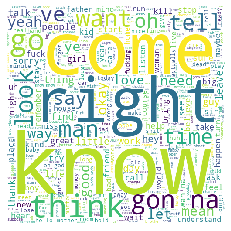

In [176]:
wc_1940_2020 = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(movie_df_1940_2020['normalized_tokens'].sum()))
plt.imshow(wc_1940_2020)
plt.axis("off")
plt.savefig("movieWC_1940_2020.pdf", format = 'pdf')

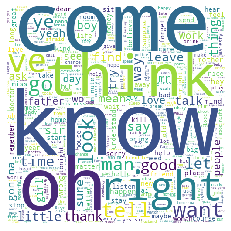

In [177]:
wc_1940_1960 = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(movie_df_1940_1960['normalized_tokens'].sum()))
plt.imshow(wc_1940_1960)
plt.axis("off")
plt.savefig("movieWC_1940_1960.pdf", format = 'pdf')

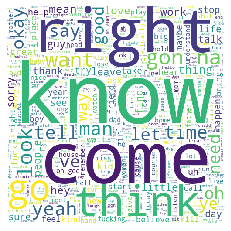

In [178]:
wc_2000_2020 = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(movie_df_2000_2020['normalized_tokens'].sum()))
plt.imshow(wc_2000_2020)
plt.axis("off")
plt.savefig("movieWC_2000_2020.pdf", format = 'pdf')

In [150]:
################################################
########## COUNTING WORDS AND PHRASES ##########
############## GENRE SUB-ANALYSIS ##############
################################################

In [151]:
countsDict = {}
for word in movieDrama['Tokenized Texts'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts_movieDrama = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)

In [152]:
countsDict = {}
for word in movieComedy['Tokenized Texts'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts_movieComedy = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)

In [153]:
countsDict = {}
for word in movieDoc['Tokenized Texts'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts_movieDoc = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)

In [154]:
word_counts_movieDrama[:5]

[('I', 14260), ('you', 10603), ('the', 7848), ('to', 7150), ("'s", 6039)]

In [155]:
word_counts_movieComedy[:5]

[('I', 11955), ('you', 9554), ('the', 7794), ("'s", 6304), ('a', 6169)]

In [156]:
word_counts_movieDoc[:5]

[('the', 7351), ('I', 4847), ('to', 4458), ('a', 3745), ('of', 3483)]

In [157]:
# .sum() adds together the lists from each row into a single list
moviecfdist_movieDrama = nltk.ConditionalFreqDist(((len(w), w) for w in movieDrama['normalized_tokens'].sum()))

#print the number of words
print(moviecfdist_movieDrama.N())

131798


In [158]:
# .sum() adds together the lists from each row into a single list
moviecfdist_movieComedy = nltk.ConditionalFreqDist(((len(w), w) for w in movieComedy['normalized_tokens'].sum()))

#print the number of words
print(moviecfdist_movieComedy.N())

129047


In [159]:
# .sum() adds together the lists from each row into a single list
moviecfdist_movieDoc = nltk.ConditionalFreqDist(((len(w), w) for w in movieDoc['normalized_tokens'].sum()))

#print the number of words
print(moviecfdist_movieDoc.N())

74023


In [160]:
moviecfdist_movieDrama_WordtoPOS = nltk.ConditionalFreqDist(movieDrama['normalized_tokens_POS'].sum())
list(moviecfdist_movieDrama_WordtoPOS.items())[:10]

[('@@5992934', FreqDist({'NNP': 1})),
 ('good', FreqDist({'JJ': 963, 'NN': 22, 'NNP': 7, 'RB': 3, 'UH': 3})),
 ('morning', FreqDist({'NN': 224, 'NNP': 4})),
 (',', FreqDist({',': 21363})),
 ('kitty', FreqDist({'NNP': 2})),
 ('!', FreqDist({'.': 3416, ',': 14, 'NNP': 9, 'NN': 4, 'SYM': 1})),
 ('come', FreqDist({'VB': 961, 'VBP': 94, 'VBN': 40, 'NN': 6, 'VBD': 3})),
 ('in', FreqDist({'IN': 2764, 'RP': 201, 'RB': 183, 'NN': 2})),
 ('here', FreqDist({'RB': 1532})),
 ('baby', FreqDist({'NN': 200, 'NNP': 1}))]

In [161]:
moviecfdist_movieComedy_WordtoPOS = nltk.ConditionalFreqDist(movieComedy['normalized_tokens_POS'].sum())
list(moviecfdist_movieComedy_WordtoPOS.items())[:10]

[('@@3904983', FreqDist({'UH': 1})),
 ('well', FreqDist({'UH': 926, 'RB': 193, 'JJ': 3, 'NN': 1})),
 (',', FreqDist({',': 22923})),
 ('what', FreqDist({'WP': 2896, 'WDT': 136})),
 ("'s", FreqDist({'VBZ': 5176, 'POS': 912, 'PRP': 414})),
 ('the', FreqDist({'DT': 9001})),
 ('matter', FreqDist({'NN': 66, 'VB': 33, 'RB': 12, 'JJ': 1})),
 ('now', FreqDist({'RB': 1024, 'UH': 18})),
 ('?', FreqDist({'.': 9980, ',': 141, 'NNP': 2, 'NN': 2})),
 ('-',
  FreqDist({':': 8229, 'HYPH': 2165, ',': 60, 'JJ': 44, 'NN': 27, '.': 18, 'SYM': 17, 'VB': 6, 'VBN': 3, 'NNS': 3, ...}))]

In [162]:
moviecfdist_movieDoc_WordtoPOS = nltk.ConditionalFreqDist(movieDoc['normalized_tokens_POS'].sum())
list(moviecfdist_movieDoc_WordtoPOS.items())[:10]

[('@@3083349', FreqDist({'NNP': 1})),
 ('look', FreqDist({'VB': 167, 'VBP': 55, 'NN': 17})),
 ('!', FreqDist({'.': 946, ',': 5})),
 ('kanako', FreqDist({'NNP': 1})),
 ('was', FreqDist({'VBD': 2422})),
 ('a', FreqDist({'DT': 3891, 'RB': 10})),
 ('penguin', FreqDist({'NN': 3})),
 ('why', FreqDist({'WRB': 229})),
 ('i', FreqDist({'PRP': 4846, 'NNP': 4})),
 ('?', FreqDist({'.': 2491, ',': 20, 'NNP': 3}))]

In [163]:
moviecfdist_movieDrama_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in movieDrama['normalized_tokens_POS'].sum())
moviecfdist_movieComedy_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in movieComedy['normalized_tokens_POS'].sum())
moviecfdist_movieDoc_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in movieDoc['normalized_tokens_POS'].sum())

In [164]:
moviecfdist_movieDrama_POStoWord['JJ']

FreqDist({'good': 963, 'right': 493, 'little': 451, 'sorry': 377, 'old': 312, 'other': 272, 'great': 237, 'last': 224, 'nice': 217, 'big': 193, ...})

In [165]:
moviecfdist_movieComedy_POStoWord['JJ']

FreqDist({'good': 918, 'little': 586, 'right': 558, 'great': 336, 'sorry': 314, 'old': 259, 'okay': 249, 'nice': 247, 'big': 237, 'last': 218, ...})

In [166]:
moviecfdist_movieDoc_POStoWord['JJ']

FreqDist({'good': 288, 'first': 240, 'other': 233, 'great': 229, 'little': 192, 'new': 156, 'many': 142, 'right': 141, 'different': 141, 'same': 139, ...})

In [167]:
moviecfdist_movieDrama_POStoWord['NN'].most_common(5)

[('man', 737), ('time', 734), ('something', 502), ('way', 403), ('day', 338)]

In [168]:
moviecfdist_movieComedy_POStoWord['NN'].most_common(5)

[('time', 665), ('man', 577), ('way', 408), ('something', 392), ('thing', 344)]

In [169]:
moviecfdist_movieDoc_POStoWord['NN'].most_common(5)

[('time', 402), ('man', 335), ('way', 280), ('something', 242), ('life', 214)]

In [170]:
moviecpdist_movieDrama_POStoWord = nltk.ConditionalProbDist(moviecfdist_movieDrama_POStoWord, nltk.ELEProbDist)

#print the most common nouns
print(moviecpdist_movieDrama_POStoWord['NN'].max())

#And its probability
print(moviecpdist_movieDrama_POStoWord['NN'].prob(moviecpdist_movieDrama_POStoWord['NN'].max()))

man
0.018374567107656278


In [171]:
moviecpdist_movieComedy_POStoWord = nltk.ConditionalProbDist(moviecfdist_movieComedy_POStoWord, nltk.ELEProbDist)

#print the most common nouns
print(moviecpdist_movieComedy_POStoWord['NN'].max())

#And its probability
print(moviecpdist_movieComedy_POStoWord['NN'].prob(moviecpdist_movieComedy_POStoWord['NN'].max()))

time
0.01620798830979055


In [172]:
moviecpdist_movieDoc_POStoWord = nltk.ConditionalProbDist(moviecfdist_movieDoc_POStoWord, nltk.ELEProbDist)

#print the most common nouns
print(moviecpdist_movieDoc_POStoWord['NN'].max())

#And its probability
print(moviecpdist_movieDoc_POStoWord['NN'].prob(moviecpdist_movieDoc_POStoWord['NN'].max()))

time
0.01513840830449827


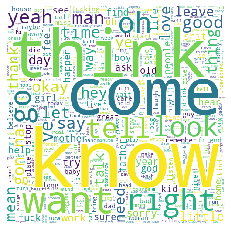

In [179]:
wc_movieDrama = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(movieDrama['normalized_tokens'].sum()))
plt.imshow(wc_movieDrama)
plt.axis("off")
plt.savefig("movieWC_Drama.pdf", format = 'pdf')

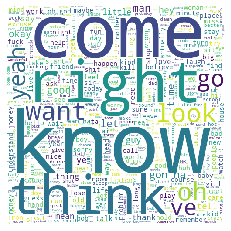

In [180]:
wc_movieComedy = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(movieComedy['normalized_tokens'].sum()))
plt.imshow(wc_movieComedy)
plt.axis("off")
plt.savefig("movieWC_Comedy.pdf", format = 'pdf')

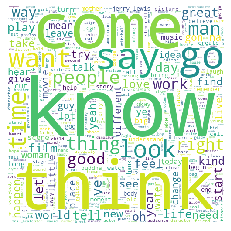

In [181]:
wc_movieDoc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(movieDoc['normalized_tokens'].sum()))
plt.imshow(wc_movieDoc)
plt.axis("off")
plt.savefig("movieWC_Doc.pdf", format = 'pdf')